In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
plt.rcParams.update({'font.size': 13})

# Import dữ liệu

In [3]:
import os
import polars as pl

def plot_box_plot(column_name, device_name, dfs, measure_dates):
    plt.figure(figsize=(14, 6))
    labels = []
    means = []
    q1s = []
    q3s = []
    min_vals = []
    max_vals = []
    
    for i, (df, label, date) in enumerate(zip(dfs, 
                                              ['Lần đo 1', 'Lần đo 2', 'Lần đo 3', 'Lần đo 4'],
                                              measure_dates), start=1):
        time_series = df[column_name]
        plt.boxplot(time_series, positions=[i], widths=0.6)
        
        # Calculate statistics
        mean = time_series.mean()
        q1 = time_series.quantile(0.25)
        q3 = time_series.quantile(0.75)
        max_val = time_series.max()
        min_val = time_series.min()
        labels.append(f'{date}_{label}')
        means.append(mean)
        q1s.append(q1)
        q3s.append(q3)
        min_vals.append(min_val)
        max_vals.append(max_val)
    plt.xticks(range(1, 5), labels)
    plt.ylabel(column_name)
    plt.title(f'Box plot {column_name}, thiết bị {device_name}')
    plt.tight_layout()
    plt.show()
    
def plot_time_series(column_name, device_name, dfs, measure_dates, starts = [0, 0, 0, 0], ends = [None, None, None, None]):
    
    plt.figure(figsize=(14, 8))
    # Determine the y-axis limits
    y_min = min(df[column_name].min() for df in dfs if df is not None)
    y_max = max(df[column_name].max() for df in dfs if df is not None)
    
    # Add some padding to the y-axis limits
    y_min = y_min - 0.1 * abs(y_min)
    y_max = y_max + 0.1 * abs(y_max)
        
    for i, (df, label, start, end, date) in enumerate(zip(dfs, 
                                                    ['Lần đo 1', 'Lần đo 2', 'Lần đo 3', 'Lần đo 4'], 
                                                    starts, 
                                                    ends, 
                                                    measure_dates), start=1):
        if df is not None:
            plt.subplot(2, 2, i)
            plt.plot(df[column_name][start:end], label=f'{label} - {column_name}')
            plt.ylabel(column_name)
            plt.ylim(y_min, y_max)  # Set the same y-axis limits for all subplots
            plt.title(f'{date} - {label}')
            plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
def plot_multiple_distributions(column_name, device_name, unit_name, dfs, measure_dates):
    plt.figure(figsize=(10, 6))
    
    for i, (df, label, date) in enumerate(zip(dfs, 
                                              ['Lần đo 1', 'Lần đo 2', 'Lần đo 3', 'Lần đo 4'], 
                                              measure_dates), start=1):
        array = df[column_name].to_numpy()
        plt.hist(array, bins=1000, alpha=0.5, label=f'{date} - {label}')
    
    plt.xlabel(unit_name)
    plt.ylabel('Frequency')
    plt.title(f'Phổ của cột {column_name} - {device_name}')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Chọn hàng - tổ hợp
def get_data(data_info_df, select_row):

    # Import dữ liệu
    base_path = "/opt/nilm-shared-data/nilm_device_detection/ICTA2024_dataset/fix_raw_data"
    data_paths = [data_info_df.iloc[select_row][f"data{i}"].replace(".xlsx", ".csv") for i in range(1, 5)]

    # Get measure dates
    measure_dates = [path.split("_")[0] for path in data_paths]

    # Load data
    dfs = []
    for path in data_paths:
        file_path = f"{base_path}/{path}"
        if os.path.isfile(file_path):
            df = pd.read_csv(file_path)
        else:
            df = None
        dfs.append(df)
    return dfs, measure_dates

# Kiểm tra patterns trong time series

In [3]:
data_info = "/opt/nilm-shared-data/nilm_device_detection/ICTA2024_dataset/data_information/data_information.xlsx"
data_info_df = pd.read_excel(data_info)
data_info_df.head()

,index,combination,data1,data2,data3,data4
0,0,[0],20240121_data_Nodevice_1.xlsx,20240121_data_Nodevice_2.xlsx,20240121_data_Nodevice_3.xlsx,20240121_data_Nodevice_4.xlsx
1,1,[1],20240113_data_den_1.xlsx,20240114_data_den_2.xlsx,20240115_data_den_3.xlsx,20240121_data_den_4.xlsx
2,2,[2],20240113_data_quat_1.xlsx,20240114_data_quat_2.xlsx,20240115_data_quat_3.xlsx,20240121_data_quat_4.xlsx
3,3,"[1, 2]",20240114_data_den_quat_1.xlsx,20240114_data_den_quat_2.xlsx,20240115_data_den_quat_3.xlsx,20240121_data_den_quat_4.xlsx
4,4,[3],20240113_data_maysay_1.xlsx,20240114_data_maysay_2.xlsx,20240115_data_maysay_3.xlsx,20240121_data_maysay_4.xlsx


In [4]:
def get_combination_name(combination): 
    device_dict = {
        0: "Không thiết bị",
        1: "LED",
        2: "Quạt",
        3: "Máy sấy",
        4: "Máy lọc KK",
        5: "Máy ép",
        6: "Ấm nước",
        7: "Sạc Laptop"
    }
    combination = combination.replace("]", "").replace("[", "").split(", ")
    combination = [int(item) for item in combination]
    combination_name = ""
    for item in combination:
        combination_name += device_dict[item] + " + "
    combination_name = combination_name.rstrip(" + ")
    return combination_name
    
# for i, row in data_info_df.iterrows():
#     print(f"{i}. {get_combination_name(row['combination'])}")

In [ ]:
for select_row in range(0, 128):
    original_dfs, measure_dates = get_data(data_info_df, select_row)
    file_name = data_info_df.iloc[select_row]["data1"]
    combinan = data_info_df.iloc[select_row]["combination"]
    combination_name = get_combination_name(combinan)
    print(f"[+] Tổ hợp {select_row}: {combination_name}")
    plot_time_series("currentWaveform", combination_name, original_dfs, measure_dates)

# Check transform data

In [12]:
train_df = pd.read_csv("/opt/nilm-shared-data/nilm_device_detection/ICTA2024_dataset/train_val_test/window_1800/train.csv")

In [14]:
val_df = pd.read_csv("/opt/nilm-shared-data/nilm_device_detection/ICTA2024_dataset/train_val_test/window_1800/val.csv")

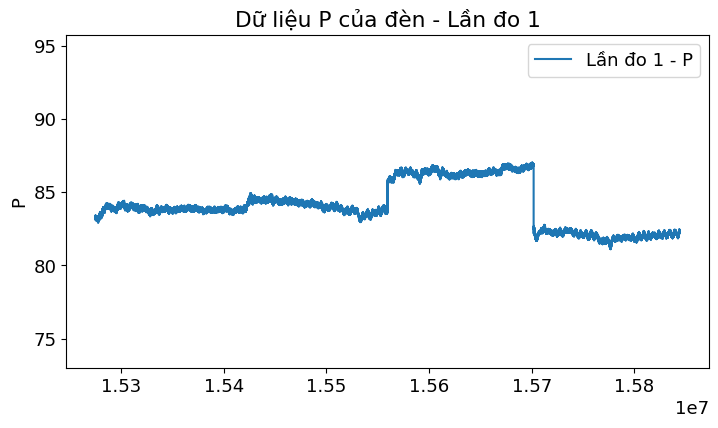

In [22]:
data_label = train_df[train_df["Label"] == 99]
plot_time_series("P", "Dữ liệu P của đèn", [data_label], ["Dữ liệu P của đèn"])

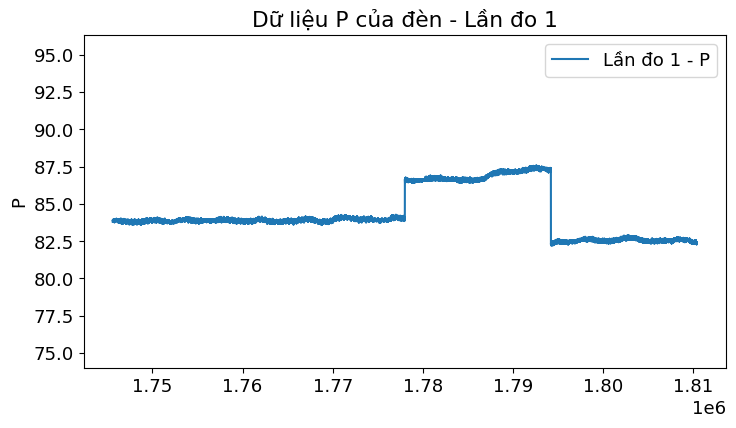

In [21]:
val_df["Label"].unique()
data_label = val_df[val_df["Label"] == 99]
plot_time_series("P", "Dữ liệu P của đèn", [data_label], ["Dữ liệu P của đèn"])